In [1]:
import torch as torch
import torchvision as tv
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.image as image
from torch.utils.data import DataLoader
import numpy as np
import os
import os.path
from torch import nn
from pdb import set_trace
from utils import show_images, show_outputs, Downsample, Noise, SSIM
from dataset import MNISTsuperimposed
from models import UpsamplingTransformer

In [2]:
transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),
     Downsample(),
     Noise(mean=0, dev=0)
     ])
target_transform= transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor()
     ])
train_superimposed = MNISTsuperimposed("./MNIST data/train", train = True, download = True, transform = transform, target_transform=target_transform)
test_supserimposed = MNISTsuperimposed("./MNIST data/train", train = False, download = True, transform = transform, target_transform=target_transform)

In [3]:
trainset = DataLoader(train_superimposed, batch_size=64)

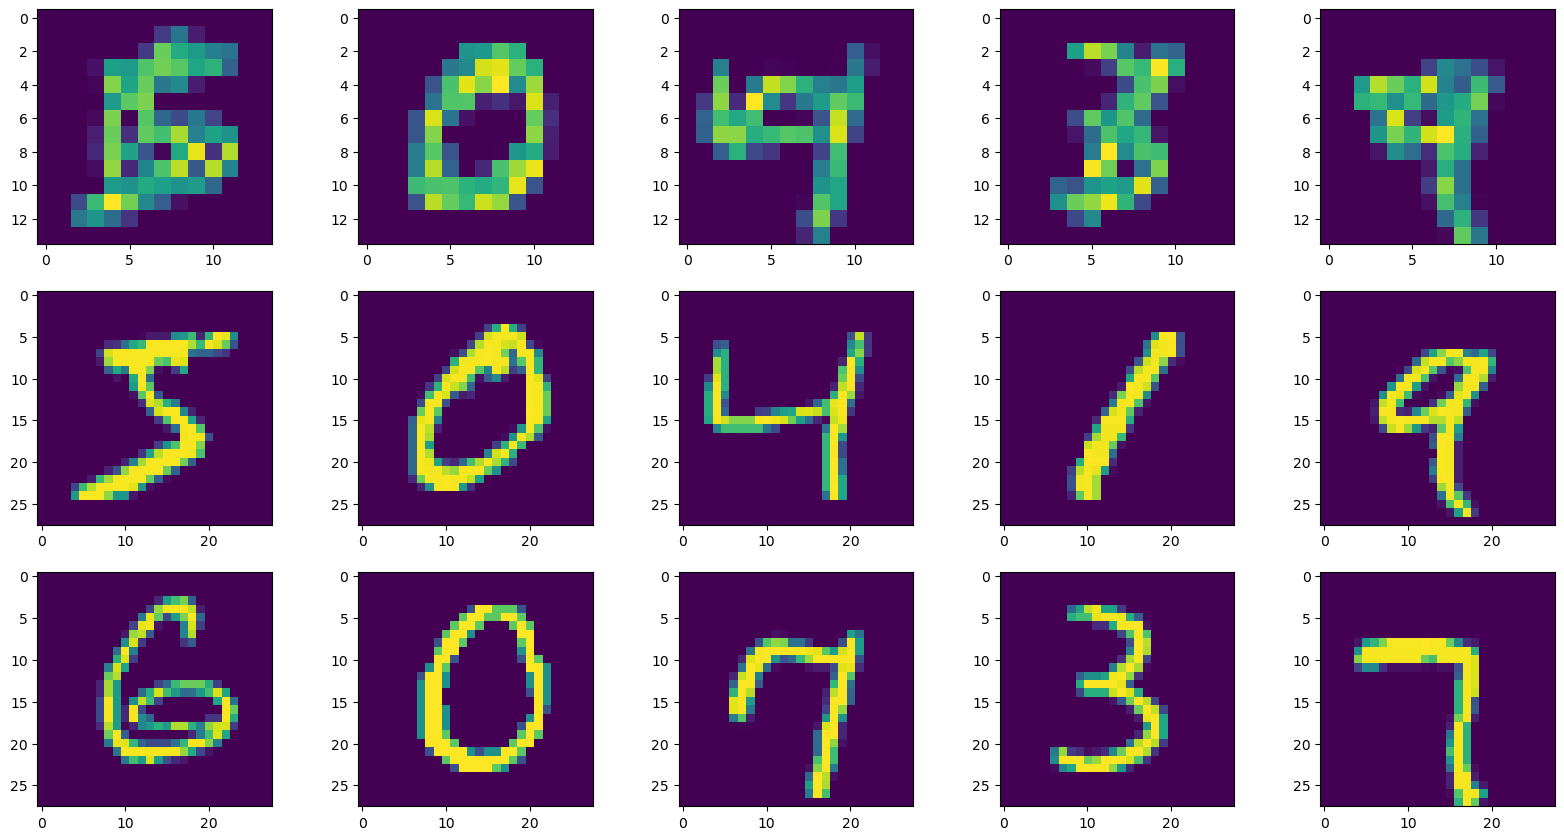

In [4]:
inputs, outputs = next(iter(trainset))
show_images(inputs, outputs)

In [39]:
model = UpsamplingTransformer(
    d_model=128,
    encoder_feedforward=256,
    decoder_feedforward=256,
    encoder_heads=128,
    decoder_heads=128,
    num_decoder_layers=3,
    num_encoder_layers=3,
    upscale=1
).cuda()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
Huber = nn.HuberLoss()
ssim = SSIM()
print('Number of model parameter: '+str(sum([parameter.numel() for parameter in model.parameters()])))

Number of model parameter: 1114822


In [40]:
epochs = 100
train_loss = []
flag = True
for epoch in range(epochs):
    for i, (inputs, targets) in enumerate(trainset):
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = Huber(targets.to(device), outputs.to(device)) + 1 - ssim(targets.to(device), outputs.to(device))
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        if i % 100 == 99:
            print('[%d, %5d] avg loss per image : %.6f' %
                  (epoch + 1, i + 1, loss.item()))
        
print('Finished Training')
flag = False

[1,   100] avg loss per image : 3865.366699
[1,   200] avg loss per image : 3637.325684
[1,   300] avg loss per image : 3571.605957
[1,   400] avg loss per image : 3529.105957
[1,   500] avg loss per image : 3637.729004
[1,   600] avg loss per image : 3369.335938
[1,   700] avg loss per image : 3486.585449
[1,   800] avg loss per image : 3701.728516
[1,   900] avg loss per image : 3715.254883
[2,   100] avg loss per image : 3549.002441
[2,   200] avg loss per image : 3517.655762
[2,   300] avg loss per image : 3454.617188


KeyboardInterrupt: 

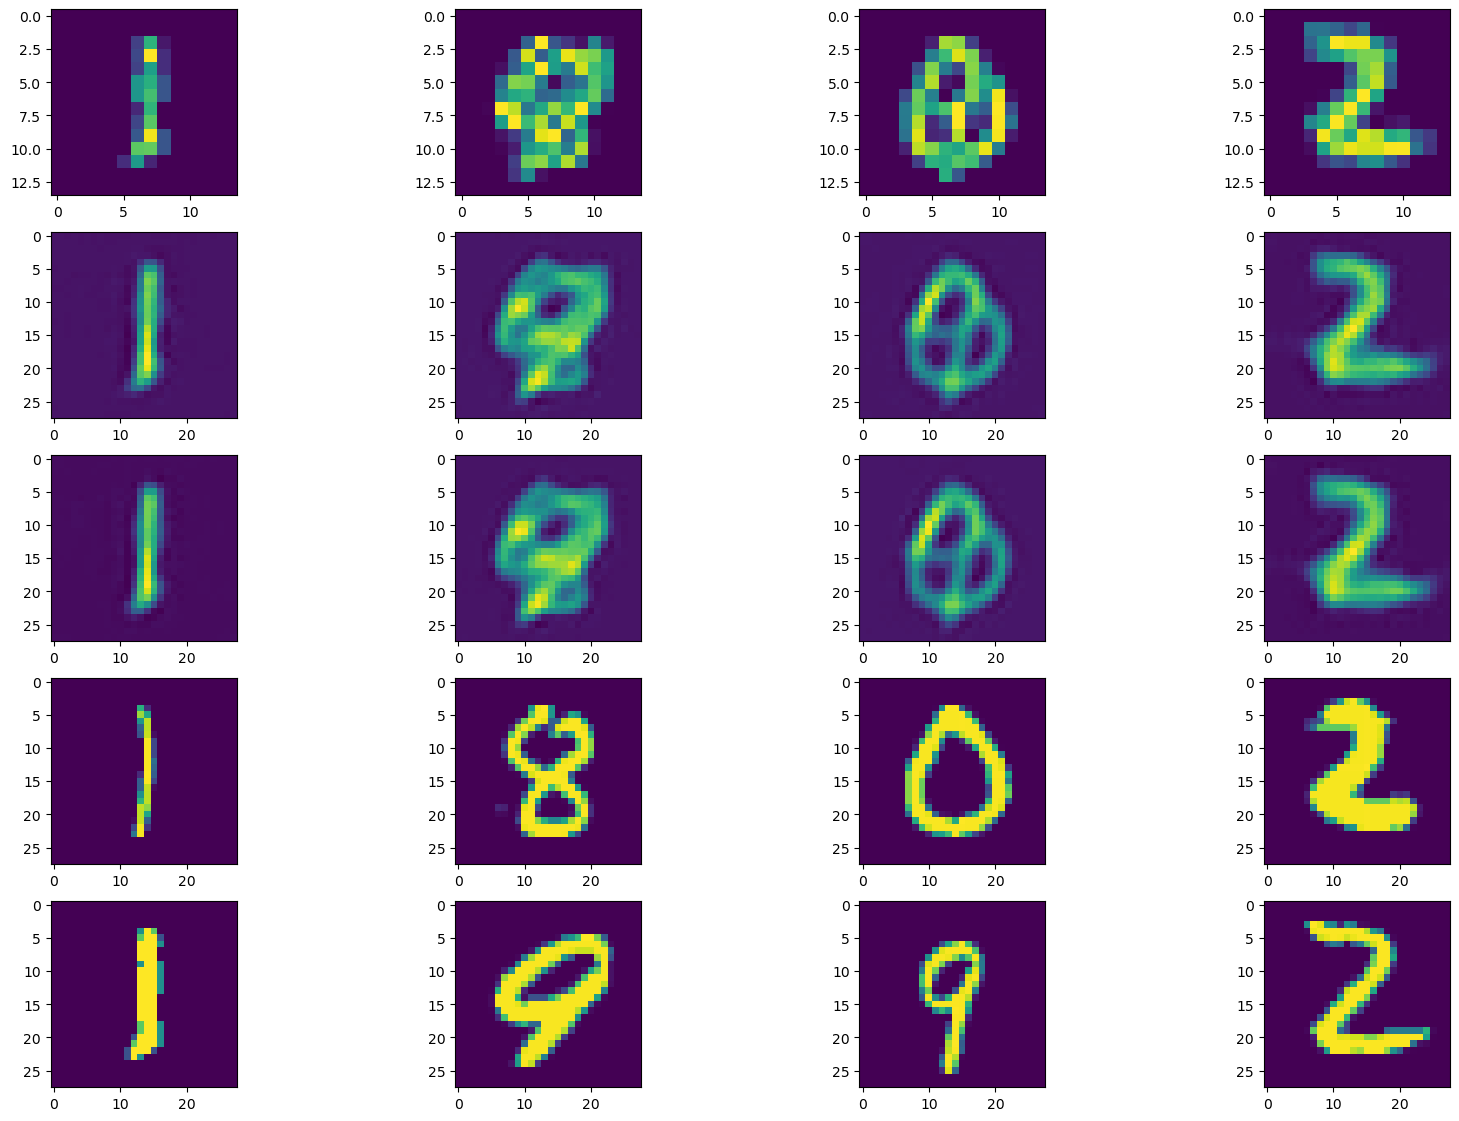

In [7]:
testset = DataLoader(test_supserimposed, batch_size=64, shuffle=True)
inputs,targets = next(iter(testset))
outputs = model(inputs.to(device))
show_outputs(outputs, targets, inputs)

In [13]:
latent = 256
class Stackedencoder1(nn.Module):
    def __init__(self, latent):
        super(Stackedencoder1,self).__init__()

        self.encode = nn.Sequential(
            nn.Linear(28*28,latent),
            nn.ReLU())
        self.decode = nn.Sequential(
            nn.Linear(latent, 28*28),
            nn.ReLU())
        self.final = nn.Sequential(
            nn.Linear(28*28, 784*2), #change this if recovering image instead of classifying
            nn.Sigmoid())
    def forward(self, x):
        # vectorize
        x = x.view(-1,28*28)
        # autoencoder1
        out = self.encode(x)
        out = self.decode(out)
        # autoencoder2
        out = self.encode(out)
        out = self.decode(out)
        # autoencoder3
        out = self.encode(out)
        out = self.decode(out)
        # final layer
        out = self.final(out)
        # spliting into two image
        out = out.view(-1, 10, 2)
        out1 = out[:,:,0]
        out2 = out[:,:,1]
        return out1, out2
    
stackedEncoder = Stackedencoder1(latent=256)

In [14]:
print(sum([parameter.numel() for parameter in stackedEncoder.parameters()]))

1633328
